In [6]:
%pip -q install adjustText

In [7]:
import re
from collections import Counter
from itertools import combinations
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("covid_instagram.csv")

In [9]:
LANG_FILTER_ON = True
LANG_CODE = "en"

K_PER_POST = 12
MIN_DF = 20
TOP_EDGES = 50_000
TOP_NODES_DRAW = 100
RANDOM_SEED = 42

TEXT_COL = "Post Description"
SENT_COL = "Sentiment"

In [10]:
HASHTAG_RE = re.compile(r"#(\w+)", flags=re.UNICODE)

def extract_hashtags(text: str):
    if not isinstance(text, str):
        return []
    tags = HASHTAG_RE.findall(text.lower())
    tags = [t for t in tags if not t.isdigit()]
    return tags

df = df.copy()
df["hashtags"] = df[TEXT_COL].apply(extract_hashtags)

if LANG_FILTER_ON and "Language Code" in df.columns:
    df = df[df["Language Code"].astype(str).str.lower() == LANG_CODE].copy()

df_ht = df[df["hashtags"].map(len) >= 2].copy()
print("Posts total:", len(df), "| with >=2 hashtags:", len(df_ht))

Posts total: 343041 | with >=2 hashtags: 337520


In [11]:
df_ht["hashtags"] = df_ht["hashtags"].apply(lambda tags: tags[:K_PER_POST])

In [12]:
tag_counts = Counter([h for tags in df_ht["hashtags"] for h in tags])
keep_tags = {h for h, c in tag_counts.items() if c >= MIN_DF}
print("Unique hashtags before MIN_DF:", len(tag_counts), "| after MIN_DF:", len(keep_tags))

df_ht["hashtags"] = df_ht["hashtags"].apply(lambda tags: [h for h in tags if h in keep_tags])
df_ht = df_ht[df_ht["hashtags"].map(len) >= 2].copy()
print("Posts after MIN_DF filtering:", len(df_ht))

tag_counts = Counter([h for tags in df_ht["hashtags"] for h in tags])

Unique hashtags before MIN_DF: 270373 | after MIN_DF: 13827
Posts after MIN_DF filtering: 327090


In [13]:
edge_all = Counter()
edge_pos = Counter()
edge_neg = Counter()

for _, row in df_ht.iterrows():
    tags = sorted(set(row["hashtags"]))
    if len(tags) < 2:
        continue

    for u, v in combinations(tags, 2):
        edge_all[(u, v)] += 1

    s = str(row.get(SENT_COL, "")).lower()
    target = None
    if s == "positive":
        target = edge_pos
    elif s == "negative":
        target = edge_neg

    if target is not None:
        for u, v in combinations(tags, 2):
            target[(u, v)] += 1

print("Edges (unique pairs) counted:",
      "all =", len(edge_all),
      "| pos =", len(edge_pos),
      "| neg =", len(edge_neg))

Edges (unique pairs) counted: all = 811654 | pos = 550275 | neg = 271401


In [14]:
def build_graph_from_edges(edge_counter: Counter, top_edges: int) -> nx.Graph:
    G = nx.Graph()
    for (u, v), w in edge_counter.most_common(top_edges):
        G.add_edge(u, v, weight=int(w))
    return G

G_all = build_graph_from_edges(edge_all, TOP_EDGES)
G_pos = build_graph_from_edges(edge_pos, TOP_EDGES)
G_neg = build_graph_from_edges(edge_neg, TOP_EDGES)

print("Graph sizes:",
      "G_all nodes/edges =", G_all.number_of_nodes(), G_all.number_of_edges(),
      "| G_pos nodes/edges =", G_pos.number_of_nodes(), G_pos.number_of_edges(),
      "| G_neg nodes/edges =", G_neg.number_of_nodes(), G_neg.number_of_edges())

Graph sizes: G_all nodes/edges = 6619 50000 | G_pos nodes/edges = 6775 50000 | G_neg nodes/edges = 6227 50000


In [15]:
top_hashtags = tag_counts.most_common(20)
print("\nTop hashtags (by frequency):")
for h, c in top_hashtags:
    print(f"{h:25s} {c}")

deg_cent = nx.degree_centrality(G_all)
top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:20]
print("\nTop hashtags (degree centrality in G_all):")
for h, c in top_deg:
    print(f"{h:25s} {c:.4f}")


Top hashtags (by frequency):
covid19                   86495
covidtesting              71297
covid                     67995
coronavirus               59016
covid_19                  41634
coronavirusupdates        37145
urgentcare                30516
primarycare               27488
familycare                27056
afccares                  26647
americanfamilycare        26598
pediatricurgentcare       26360
pediatriccare             26360
physicalexam              26298
sportsphysical            26177
telehealth                25778
healthmatters             22529
covidvaccine              21260
coronavirusoutbreak       18817
covidpandemic             18003

Top hashtags (degree centrality in G_all):
covid19                   0.3137
covid                     0.2628
coronavirus               0.2182
covid_19                  0.1892
covidtesting              0.1848
coronavirusupdates        0.1117
covidvaccine              0.0858
health                    0.0820
pandemic              

In [16]:
from networkx.algorithms.community import greedy_modularity_communities

top_nodes = [h for h, _ in tag_counts.most_common(TOP_NODES_DRAW)]
H = G_all.subgraph(top_nodes).copy()

communities = list(greedy_modularity_communities(H))
print("\nCommunities found (on top-node subgraph):", len(communities))
for i, comm in enumerate(communities[:8], start=1):
    comm_list = list(comm)
    comm_list = sorted(comm_list, key=lambda x: tag_counts[x], reverse=True)
    print(f"Community {i:02d} (size={len(comm_list)}):", ", ".join(comm_list[:15]))


Communities found (on top-node subgraph): 3
Community 01 (size=45): coronavirusupdates, coronavirusoutbreak, covidpandemic, staysafe, corona, pandemic, covidupdate, vaccine, covidtest, coronaviruspandemic, stayhome, news, indiafightscorona, coronavirusvaccine, lockdown
Community 02 (size=30): covid19, covidtesting, urgentcare, primarycare, familycare, afccares, americanfamilycare, pediatricurgentcare, pediatriccare, physicalexam, sportsphysical, telehealth, healthmatters, covidvaccine, health
Community 03 (size=25): covid, coronavirus, covid_19, covidheroes, covidrelief, india, love, covidsupport, instagram, travel, education, community, rtpcr, trending, usa


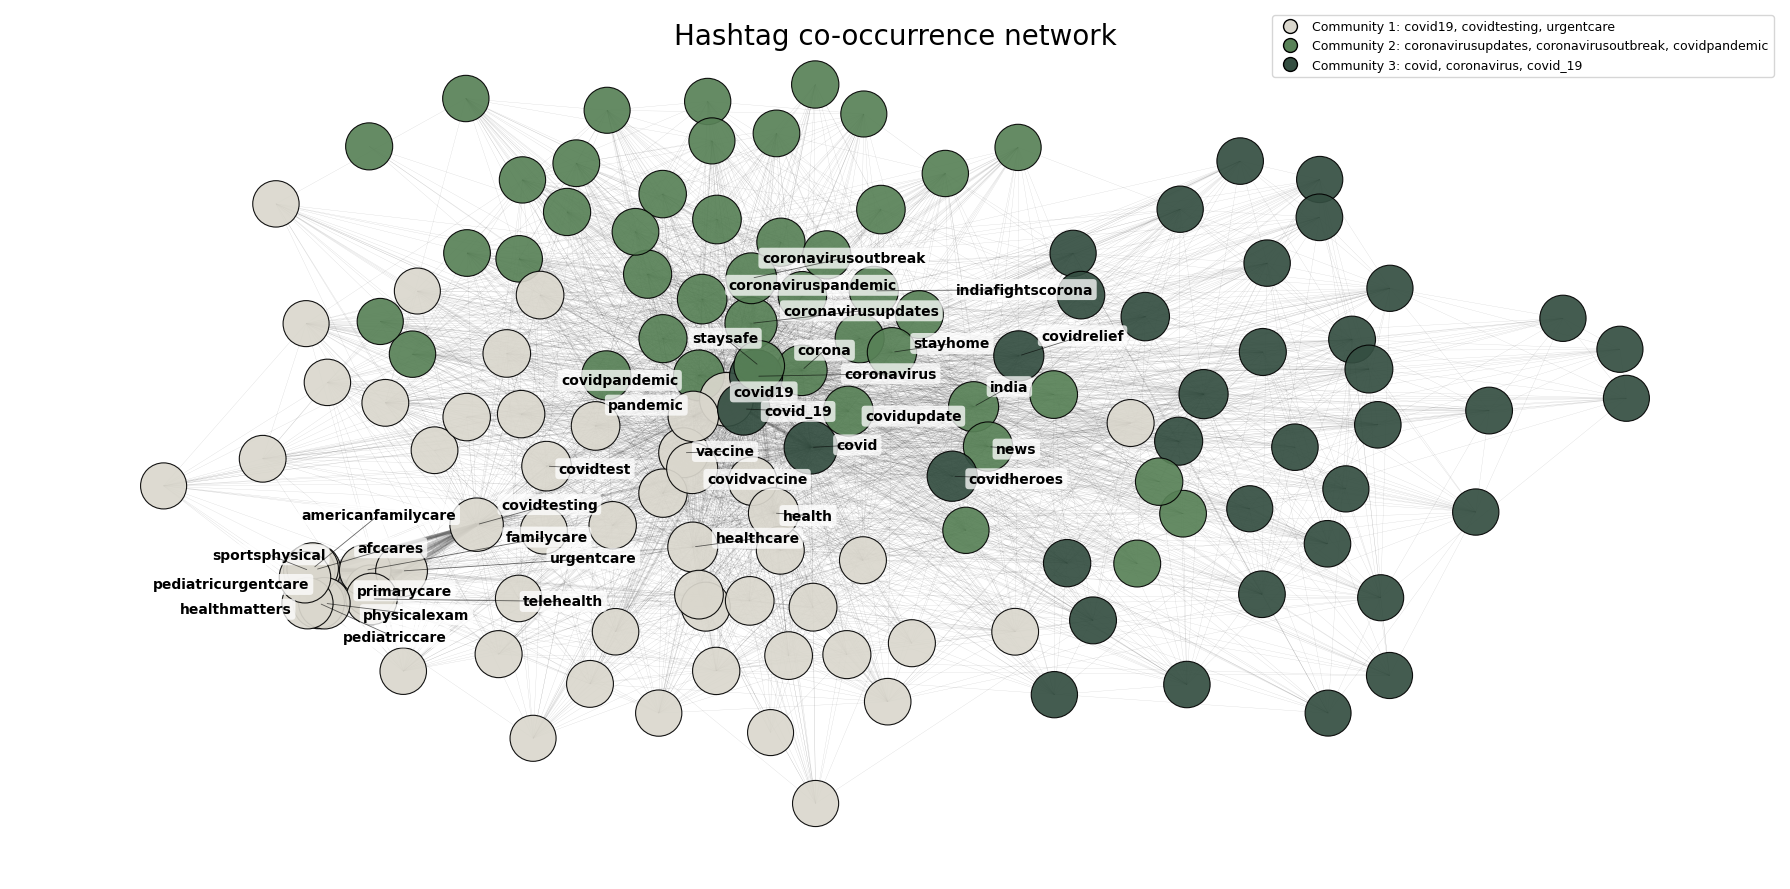

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from adjustText import adjust_text
from networkx.algorithms.community import greedy_modularity_communities

MAX_NODES = 140
LABEL_TOP = 35
SEED = 42
EDGE_ALPHA = 0.18

top_nodes = [h for h, _ in tag_counts.most_common(MAX_NODES)]
H = G_all.subgraph(top_nodes).copy()

communities = list(greedy_modularity_communities(H))

CUSTOM_COLORS = ["#DAD7CD", "#588157", "#344E41"]

node_colors = [
    CUSTOM_COLORS[node2comm.get(n, 0) % len(CUSTOM_COLORS)]
    for n in H.nodes()
]

pos = nx.spring_layout(H, seed=SEED, k=0.45, weight="weight", iterations=200)

node_sizes = [
    300 + 1200 * np.log1p(tag_counts[n]) / np.log1p(max(tag_counts.values()))
    for n in H.nodes()
]

if H.number_of_edges() > 0:
    w = np.array([H[u][v].get("weight", 1) for u, v in H.edges()])
    widths = np.clip((w / w.max()) * 3.0, 0.2, 3.0)
else:
    widths = []

plt.figure(figsize=(18, 9))
ax = plt.gca()
ax.set_facecolor("white")

nx.draw_networkx_edges(
    H, pos,
    width=widths,
    alpha=EDGE_ALPHA,
    edge_color="black"
)

nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors="black",
    linewidths=0.8,
    alpha=0.92
)

label_nodes = [h for h, _ in tag_counts.most_common(LABEL_TOP) if h in H.nodes()]
texts = []
for n in label_nodes:
    x, y = pos[n]
    t = plt.text(
    x, y, n,
    fontsize=10,
    fontweight="bold",
    color="black",
    bbox=dict(
        facecolor="white",
        edgecolor="none",
        alpha=0.75,
        boxstyle="round,pad=0.25"
    )
)
    texts.append(t)

adjust_text(
    texts,
    ax=ax,
    expand_points=(1.2, 1.2),
    expand_text=(1.2, 1.2),
    force_points=(0.2, 0.2),
    force_text=(0.5, 0.5),
    arrowprops=dict(arrowstyle="-", lw=0.6, alpha=0.6)
)

handles = []
labels = []
COMM_LEGEND_MAX = 10
comm_order = sorted(
    range(len(communities)),
    key=lambda i: sum(tag_counts.get(n, 0) for n in communities[i]),
    reverse=True
)[:COMM_LEGEND_MAX]

for i in comm_order:
    comm_nodes = list(communities[i])
    comm_nodes = [n for n in comm_nodes if n in tag_counts]
    comm_nodes = sorted(comm_nodes, key=lambda n: tag_counts[n], reverse=True)
    example = ", ".join(comm_nodes[:3]) if comm_nodes else "—"

    color = CUSTOM_COLORS[i % len(CUSTOM_COLORS)]
    handles.append(Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=color, markeredgecolor='black',
                          markersize=10))
    labels.append(f"Community {i+1}: {example}")

plt.legend(handles, labels, loc="upper right", frameon=True, fontsize=9)

plt.title("Hashtag co-occurrence network", fontsize=20, y=0.95)
plt.axis("off")
plt.tight_layout()
plt.show()

In [23]:
def top_edges_report(edge_counter: Counter, n=15):
    return edge_counter.most_common(n)

print("\nTop co-occurring hashtag pairs (ALL):")
for (u, v), w in top_edges_report(edge_all, 15):
    print(f"{u:18s} - {v:18s}  {w}")

print("\nTop co-occurring hashtag pairs (POSITIVE):")
for (u, v), w in top_edges_report(edge_pos, 15):
    print(f"{u:18s} - {v:18s}  {w}")

print("\nTop co-occurring hashtag pairs (NEGATIVE):")
for (u, v), w in top_edges_report(edge_neg, 15):
    print(f"{u:18s} - {v:18s}  {w}")

deg_pos = nx.degree_centrality(G_pos) if G_pos.number_of_nodes() else {}
deg_neg = nx.degree_centrality(G_neg) if G_neg.number_of_nodes() else {}

top_pos = sorted(deg_pos.items(), key=lambda x: x[1], reverse=True)[:15]
top_neg = sorted(deg_neg.items(), key=lambda x: x[1], reverse=True)[:15]

print("\nTop hashtags in POS graph (degree centrality):")
for h, c in top_pos:
    print(f"{h:25s} {c:.4f}")

print("\nTop hashtags in NEG graph (degree centrality):")
for h, c in top_neg:
    print(f"{h:25s} {c:.4f}")


Top co-occurring hashtag pairs (ALL):
coronavirus        - covid19             30811
covidtesting       - urgentcare          27134
primarycare        - urgentcare          26737
afccares           - urgentcare          26599
afccares           - americanfamilycare  26586
americanfamilycare - urgentcare          26586
familycare         - urgentcare          26452
afccares           - familycare          26361
americanfamilycare - familycare          26357
pediatricurgentcare - urgentcare          26339
pediatriccare      - urgentcare          26330
afccares           - pediatriccare       26264
afccares           - pediatricurgentcare  26261
americanfamilycare - pediatricurgentcare  26258
americanfamilycare - pediatriccare       26251

Top co-occurring hashtag pairs (POSITIVE):
covidtesting       - urgentcare          19185
primarycare        - urgentcare          18830
afccares           - urgentcare          18737
americanfamilycare - urgentcare          18727
afccares           - 